In [7]:
import cv2
import numpy as np
import toml
import os
import msgpack as mp
import msgpack_numpy as mpn
import matplotlib.pyplot as plt
from cv2 import aruco
from tqdm import tqdm
import polars as pl
import sys
sys.path.insert(1, os.path.dirname(os.getcwd()))

from pd_support import *

from scipy.spatial.transform import Rotation as R

Loading camera calibration

In [8]:
data = toml.load("../../old_calibration/undistort_fisheye_mono_1200_800.toml")
# data = toml.load("../undistort_best.toml")
# data = toml.load("../calib_mono_1200_800.toml")
# data = toml.load("../calib_undistort_aruco.toml")
# data = toml.load("../../calib_mono_faith2D.toml")  
# data = toml.load("../../calib_mono_faith3D.toml")
camera_matrix = np.array(data["calibration"]["camera_matrix"]).reshape(3, 3)
dist_coeff = np.array(data["calibration"]["dist_coeffs"])

_parent_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data")
# _parent_dir = r"E:\CMC\pyprojects\DeepVision\recorded_data\five_marker_validation"
_folder_name = "mono_raw_t1"
# _folder_name = "mono3d_angle_t0"
_base_pth = os.path.join(_parent_dir, "recordings", _folder_name)

In [9]:
_base_pth

'e:\\CMC\\pyprojects\\programs_rpi\\rpi_python\\data\\recordings\\mono_raw_t1'

In [10]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36H11)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

default_ids = [4, 8, 12, 14, 20]

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [11]:
def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs = []
    tvecs = []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            True,
            flags=cv2.SOLVEPNP_IPPE_SQUARE,
        )
        if r is not None and t is not None:
            r = np.array(r).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
            rvecs.append(r)
            tvecs.append(t)
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

In [12]:
# data = toml.load("../undistort_best.toml")
# data = toml.load("../calib_mono_1200_800.toml")
# data = toml.load("../calib_undistort_aruco.toml")
# data = toml.load("../calib_mono_faith3D.toml")
_camera_matrix = np.array(data["calibration"]["camera_matrix"]).reshape(3, 3)
_dist_coeff = np.array(data["calibration"]["dist_coeffs"])

In [13]:
rvecs, tvecs = [], []


_fish_params = toml.load(r"E:\CMC\pyprojects\programs_rpi\rpi_python\undistort_best.toml")
_fish_matrix = np.array(_fish_params["calibration"]["camera_matrix"]).reshape(3, 3)
_fish_dist = np.array(_fish_params["calibration"]["dist_coeffs"])
map1, map2 = cv2.fisheye.initUndistortRectifyMap(
    _fish_matrix, _fish_dist, np.eye(3), _fish_matrix, (1200, 800), cv2.CV_16SC2
)


with open(os.path.join(_base_pth, "webcam_color.msgpack"), "rb") as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    # img_size = next(unpacker)
    for _frame in tqdm(unpacker):
        # print(_frame)
        _frame = cv2.remap(
                _frame,
                map1,
                map2,
                interpolation=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_CONSTANT,
            )
        corners, ids, rejectedpoints = detector.detectMarkers(_frame)
        corners, ids, rejectedpoints, _ = detector.refineDetectedMarkers(
            image=_frame,
            board=board,
            detectedCorners=corners,
            detectedIds=ids,
            rejectedCorners=rejectedpoints,
        )

        if (ids is not None and len(ids) > 0) and all(
            item in default_ids for item in np.array(ids)
        ):
            rotation_vectors, translation_vectors = estimate_pose_single_markers(
                corners=corners,
                marker_size=0.05,
                camera_matrix=_camera_matrix,
                distortion_coefficients=_dist_coeff,
            )
            rvecs.append(rotation_vectors[0][0])
            tvecs.append(translation_vectors[0][0])

        else:
            rvecs.append(np.array([np.nan, np.nan, np.nan]))
            tvecs.append(np.array([np.nan, np.nan, np.nan]))

timestamp = []
sync = []

with open(os.path.join(_base_pth, "webcam_timestamp.msgpack"), "rb") as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    for _p in unpacker:
        sync.append(_p[0])
        timestamp.append(_p[1])
tvecs = np.array(tvecs)
rvecs = np.array(rvecs)
sync = np.array(sync).astype(bool)

0it [00:00, ?it/s]

4703it [00:31, 149.23it/s]


In [14]:
ar_dict = {
    "time": timestamp,
    "sync": sync,
    "x": tvecs[:, 0],
    "y": tvecs[:, 1],
    "z": tvecs[:, 2],
    "rx": rvecs[:, 0],
    "ry": rvecs[:, 1],
    "rz": rvecs[:, 2],
}
ar_df = pl.from_dict(ar_dict)
if type(ar_df["time"][0]) is not datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())

In [15]:
ar_df

time,sync,x,y,z,rx,ry,rz
datetime[μs],bool,f64,f64,f64,f64,f64,f64
2024-10-04 12:37:07.078252,false,-0.040681,-0.036078,0.289972,2.997176,-0.026177,0.177087
2024-10-04 12:37:07.088505,false,-0.040615,-0.036089,0.288865,2.969843,-0.046265,0.181852
2024-10-04 12:37:07.096652,false,-0.040681,-0.036078,0.289972,2.997176,-0.026177,0.177087
2024-10-04 12:37:07.106784,false,-0.040615,-0.036089,0.288865,2.969843,-0.046265,0.181852
2024-10-04 12:37:07.121949,false,-0.040615,-0.036089,0.288865,2.969843,-0.046265,0.181852
…,…,…,…,…,…,…,…
2024-10-04 12:37:48.121210,false,-0.060746,-0.035512,0.292898,2.964863,-0.061489,0.042649
2024-10-04 12:37:48.130052,false,-0.060531,-0.035474,0.29249,2.959579,-0.054796,0.063848
2024-10-04 12:37:48.139064,false,-0.060531,-0.035474,0.29249,2.959579,-0.054796,0.063848


In [16]:
pulse_sweep = False
for idx, val in enumerate(ar_df["sync"]):
    if val == True and not pulse_sweep:
        start_pulse = idx
        pulse_sweep = True
    if val == False and pulse_sweep:
        end_pulse = idx
        break
ar_df = ar_df[start_pulse:end_pulse]

In [17]:
mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, f"{_folder_name}.csv"))
# mocap_df, st_time = read_rigid_body_csv(r"E:\CMC\pyprojects\DeepVision\recorded_data\five_marker_validation\mocap\coord_3d.csv")
mocap_df = add_datetime_col(mocap_df, st_time, "seconds")
mocap_df = pl.from_pandas(mocap_df)

e:\CMC\pyprojects\programs_rpi\rpi_python\notebooks\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [18]:
tr = get_rb_marker_name(4)
tl = get_rb_marker_name(2)
br = get_rb_marker_name(3)
bl = get_rb_marker_name(1)

In [19]:
_time_diff = ar_df["time"][0] - mocap_df["time"][0]

ar_df = ar_df.with_columns([(pl.col("time") - _time_diff).alias("time")])

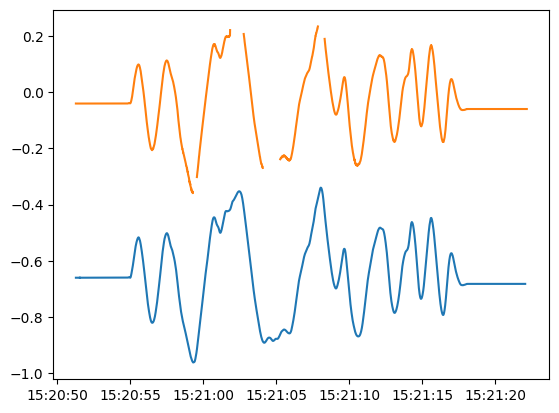

In [20]:
plt.plot(mocap_df["time"], mocap_df[tr["x"]])
plt.plot(ar_df["time"], ar_df["x"])

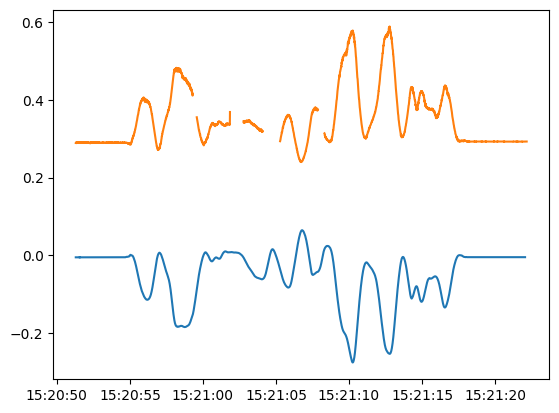

In [21]:
plt.plot(mocap_df["time"], mocap_df[tr["z"]])
plt.plot(ar_df["time"], ar_df["z"])

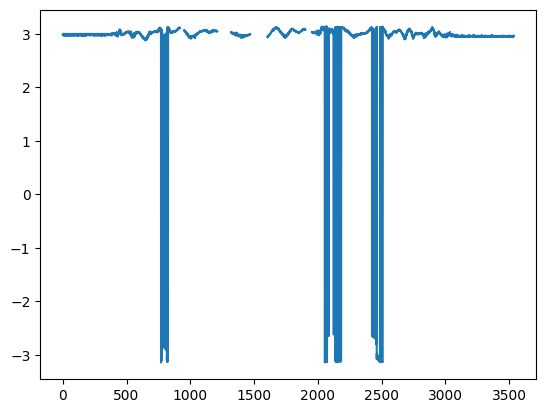

In [22]:
plt.plot(ar_df["rx"])

In [23]:
t_dict = {"x": [], "y": [], "z": []}
rmat = cv2.Rodrigues(ar_df[["rx", "ry", "rz"]][1].to_numpy())[0]

for i in range(len(ar_df["time"])):
    tvec = rmat.T @ (
        ar_df[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
        - ar_df[["x", "y", "z"]][1].to_numpy().reshape(3, 1)
    )
    tvec = tvec.T[0]
    t_dict["x"].append(tvec[0])
    t_dict["y"].append(tvec[1])
    t_dict["z"].append(tvec[2])

In [24]:
tvec

array([-0.01902625,  0.00026955, -0.0048978 ])

In [25]:
mocap_mean = {"x": [], "y": [], "z": []}
mocap_mean["x"] = mocap_df[[tr["x"], tl["x"], br["x"], bl["x"]]].to_numpy().mean(axis=1)
mocap_mean["y"] = mocap_df[[tr["y"], tl["y"], br["y"], bl["y"]]].to_numpy().mean(axis=1)
mocap_mean["z"] = mocap_df[[tr["z"], tl["z"], br["z"], bl["z"]]].to_numpy().mean(axis=1)

mocap_qt = mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]][0].to_numpy()

mocap_rotation = R.from_quat(mocap_qt).as_matrix()

In [26]:
mocap_mean = pl.from_dict(mocap_mean)

In [27]:
mt_dict = {"x": [], "y": [], "z": []}
rmat_m = mocap_rotation[0]

for i in range(len(mocap_df["time"])):
    tvec_ar = rmat_m.T @ (
        mocap_mean[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
        - mocap_mean[["x", "y", "z"]][0].to_numpy().reshape(3, 1)
    )
    tvec_ar = tvec_ar.T[0]
    mt_dict["x"].append(tvec_ar[0])
    mt_dict["y"].append(tvec_ar[1])
    mt_dict["z"].append(tvec_ar[2])

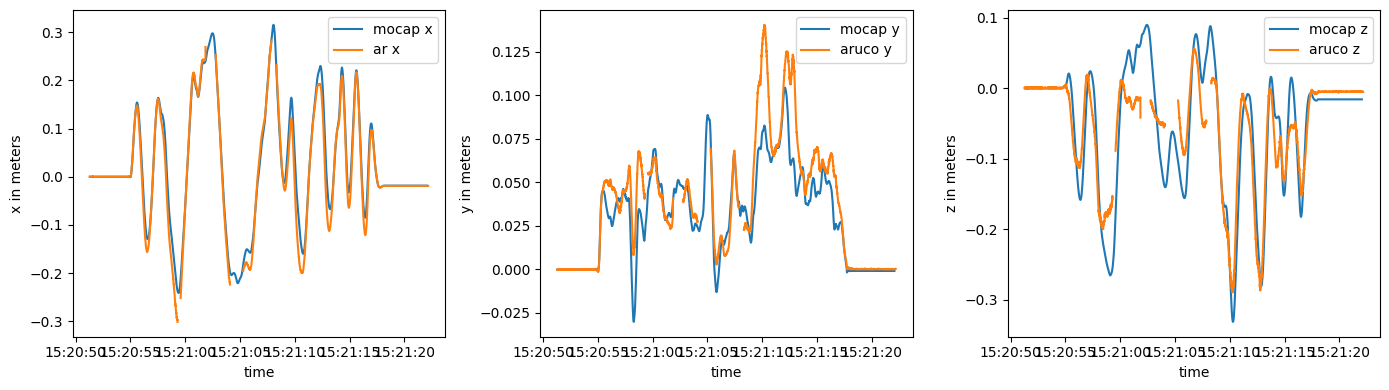

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(mocap_df["time"], mt_dict["x"], label="mocap x")
axes[0].plot(ar_df["time"], t_dict["x"], label="ar x")
axes[0].set_xlabel("time")
axes[0].set_ylabel("x in meters")
axes[0].legend()

axes[1].plot(mocap_df["time"], mt_dict["y"], label="mocap y")
axes[1].plot(ar_df["time"], t_dict["y"], label="aruco y")
axes[1].set_xlabel("time")
axes[1].set_ylabel("y in meters")
axes[1].legend()

axes[2].plot(mocap_df["time"], mt_dict["z"], label="mocap z")
axes[2].plot(ar_df["time"], np.array(t_dict["z"]), label="aruco z")
axes[2].set_xlabel("time")
axes[2].set_ylabel("z in meters")
axes[2].legend()


# axes[2].set_ylim([-0.01, 0.01])

plt.tight_layout()
plt.show()

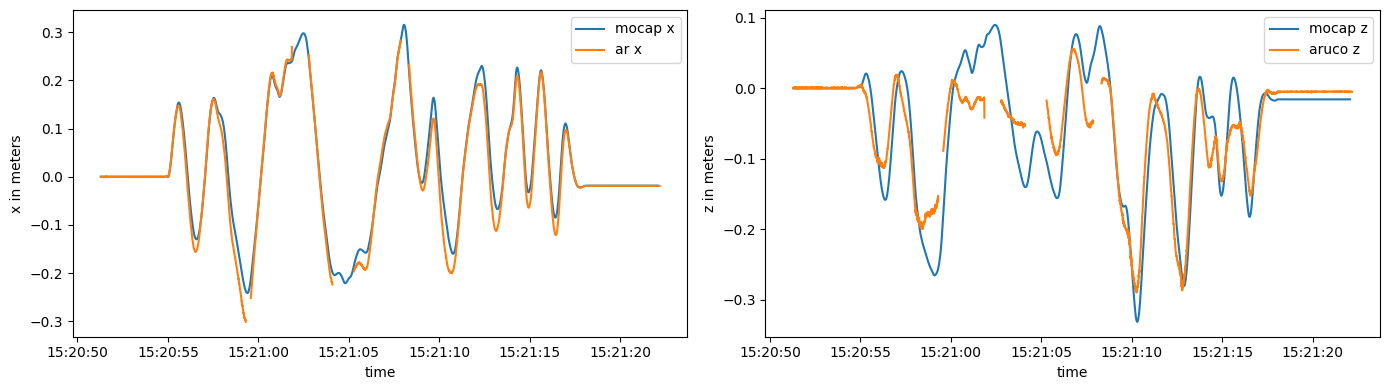

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(mocap_df["time"], mt_dict["x"], label="mocap x")
axes[0].plot(ar_df["time"], t_dict["x"], label="ar x")
axes[0].set_xlabel("time")
axes[0].set_ylabel("x in meters")
axes[0].legend()

axes[1].plot(mocap_df["time"], mt_dict["z"], label="mocap z")
axes[1].plot(ar_df["time"], np.array(t_dict["z"]), label="aruco z")
axes[1].set_xlabel("time")
axes[1].set_ylabel("z in meters")
axes[1].legend()

plt.tight_layout()
plt.show()

## Interpolation

In [30]:
mt_dict["time"] = mocap_df["time"]

In [31]:
mocap = pl.from_dict(mt_dict)

x1 = interp1d(mocap["time"].dt.epoch(), mocap["x"], fill_value="extrapolate")
y1 = interp1d(mocap["time"].dt.epoch(), mocap["y"], fill_value="extrapolate")
z1 = interp1d(mocap["time"].dt.epoch(), mocap["z"], fill_value="extrapolate")

mocap_ip = {"time": ar_df["time"]}
mocap_ip["x"] = x1(ar_df["time"].dt.epoch())
mocap_ip["y"] = y1(ar_df["time"].dt.epoch())
mocap_ip["z"] = z1(ar_df["time"].dt.epoch())
mocap_ip = pl.from_dict(mocap_ip)

In [32]:
_err_x = np.nanmean(abs(mocap_ip["x"] - np.array(t_dict["x"])))
_err_y = np.nanmean(abs(mocap_ip["y"] - np.array(t_dict["y"])))
_err_z = np.nanmean(abs(mocap_ip["z"] - np.array(t_dict["z"])))

_max_x = np.nanmax(abs(mocap_ip["x"] - np.array(t_dict["x"])))
_max_y = np.nanmax(abs(mocap_ip["y"] - np.array(t_dict["y"])))
_max_z = np.nanmax(abs(mocap_ip["z"] - np.array(t_dict["z"])))

_sd_x = np.nanstd(abs(mocap_ip["x"] - np.array(t_dict["x"])).to_numpy())
_sd_y = np.nanstd(abs(mocap_ip["y"] - np.array(t_dict["y"])).to_numpy())
_sd_z = np.nanstd(abs(mocap_ip["z"] - np.array(t_dict["z"])).to_numpy())

In [33]:
print(_sd_x*100, _sd_y*100, _sd_z*100)

1.8437516917375676 1.3731846118353044 2.5475884632547925


In [34]:
print(_err_x*100, _err_y*100, _err_z*100)

1.4332068680441359 1.0360711926383168 2.957965016608266


In [35]:
print(_max_x*100, _max_y*100, _max_z*100)

7.754919859302806 5.987628530567671 10.417273429235719


Angle

In [36]:
rvecs = ar_df[['rx', 'ry', 'rz']].to_numpy()
rmats = R.from_rotvec(rvecs).as_matrix()
rotation = np.array([_r.T @ rmats[0] for _r in rmats])
euler_ar = R.from_matrix(rotation).as_euler('ZYX', degrees=True)

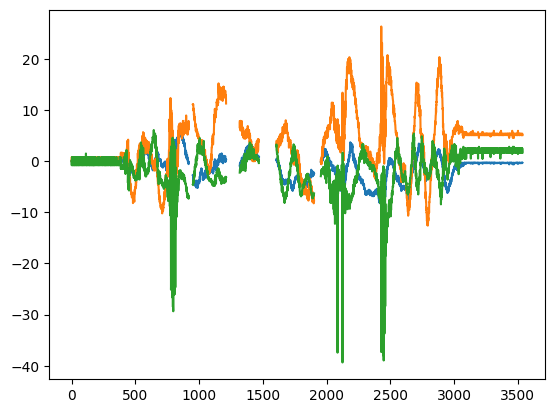

In [37]:
plt.plot(euler_ar)

In [38]:
mocap_qts = mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]].to_numpy()

mocap_rmats = []
for _q in mocap_qts:
    try:
        mocap_rmats.append(R.from_quat(_q).as_matrix())
    except:
        mocap_rmats.append(np.eye(3))
# mocap_rmats = R.from_quat(mocap_qts).as_matrix()

In [39]:
mocap_ang = [_r.T @ mocap_rmats[0] for _r in mocap_rmats]
mocap_euler = R.from_matrix(mocap_ang).as_euler('zyx', degrees=True)

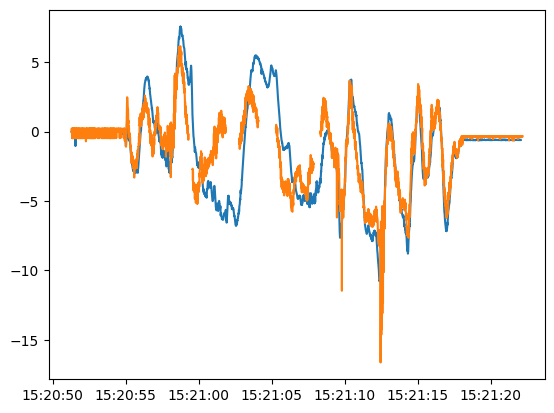

In [40]:
plt.plot(mocap_df["time"],mocap_euler[:,0])
plt.plot(ar_df["time"], euler_ar[:,0])

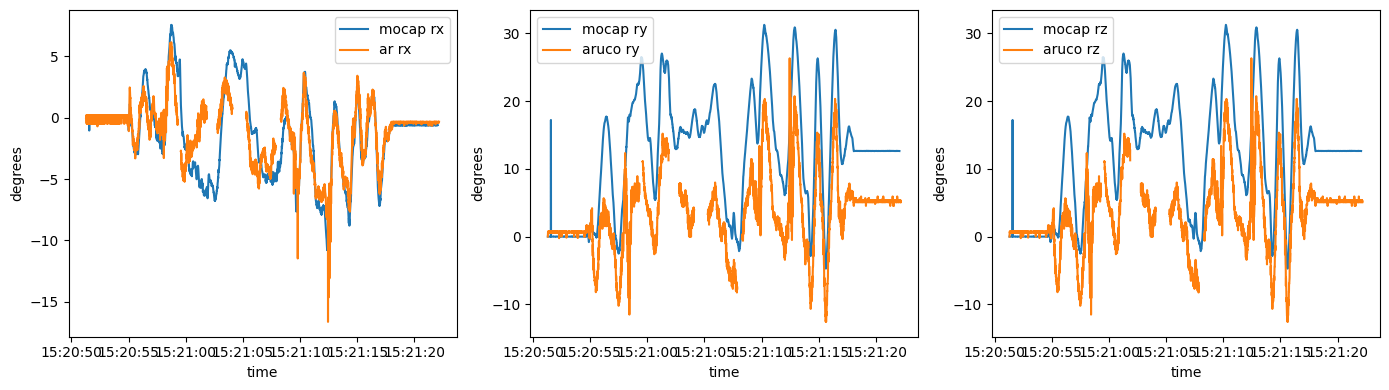

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(mocap_df["time"],mocap_euler[:,0], label="mocap rx")
axes[0].plot(ar_df["time"], euler_ar[:,0], label="ar rx")
axes[0].set_xlabel("time")
axes[0].set_ylabel("degrees")
axes[0].legend()

axes[1].plot(mocap_df["time"],mocap_euler[:,1], label="mocap ry")
axes[1].plot(ar_df["time"], euler_ar[:,1], label="aruco ry")
axes[1].set_xlabel("time")
axes[1].set_ylabel("degrees")
axes[1].legend()

axes[2].plot(mocap_df["time"],mocap_euler[:,1], label="mocap rz")
axes[2].plot(ar_df["time"], euler_ar[:,1], label="aruco rz")
axes[2].set_xlabel("time")
axes[2].set_ylabel("degrees")
axes[2].legend()


# axes[2].set_ylim([-0.01, 0.01])

plt.tight_layout()
plt.show()